<a id="top"></a>
# TSM Demo

<hr>

# Notebook Summary

TSM stands for "Total Suspended Matter" - also called TSS which stands for "Total Suspended Solids". It is the dry-weight of particles suspended (not dissolved) in a body of water. It is a proxy of water quality.

<hr>

# Index

* [Import Dependencies and Connect to the Data Cube](#import)
* [Choose Platforms and Products](#plat_prod)
* [Get the Extents of the Cube](#extents)
* [Define the Extents of the Analysis](#define_extents)
* [Load Data from the Data Cube](#load_data)
* [Obtain TSM](#obtain_tsm)
    * Mask Out Everything but Water
    * Compute TSM Over Time
    * Compute Mean TSM Over Time
    * Compute Maximum TSM Over Time
    * Compute Minimum TSM Over Time
    * Descriptive Statistics
* [GeoTIFF Output Products](#export)

## <span id="import">Import Dependencies and Connect to the Data Cube [&#9652;](#top)</span> 

In [1]:
import sys
sys.path.append('../..')

# Supress Warning 
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np  
import xarray as xr  

import utils.data_cube_utilities.data_access_api as dc_api  
api = dc_api.DataAccessApi()#config = '/home/localuser/.datacube.conf')
dc = api.dc

## <span id="plat_prod">Choose Platforms and Products [&#9652;](#top)</span>

**List available products for each platform**

In [2]:
# Get available products
products_info = dc.list_products()

# List Landsat 7 products
print("Landsat 7 Products:")
products_info[["platform", "name"]][products_info.platform == "LANDSAT_7"]

Landsat 7 Products:


,platform,name
id,,
12,LANDSAT_7,ls7_collections_sr_scene
13,LANDSAT_7,ls7_ledaps_ghana
17,LANDSAT_7,ls7_ledaps_kenya
18,LANDSAT_7,ls7_ledaps_senegal
16,LANDSAT_7,ls7_ledaps_sierra_leone
19,LANDSAT_7,ls7_ledaps_tanzania
31,LANDSAT_7,ls7_ledaps_vietnam


In [3]:
# List Landsat 8 products
print("Landsat 8 Products:")
products_info[["platform", "name"]][products_info.platform == "LANDSAT_8"]

Landsat 8 Products:


,platform,name
id,,
7,LANDSAT_8,ls8_collections_sr_scene
9,LANDSAT_8,ls8_lasrc_ghana
10,LANDSAT_8,ls8_lasrc_kenya
11,LANDSAT_8,ls8_lasrc_senegal
8,LANDSAT_8,ls8_lasrc_sierra_leone
15,LANDSAT_8,ls8_lasrc_tanzania


**Choose products**

In [4]:
# Select Products and Platforms
# It is possible to select multiple datasets (L7, L8)
# True = SELECT
# False = DO NOT SELECT

use_Landsat7 = False
use_Landsat8 = True
platforms, products = [], []
if use_Landsat7:
    platforms.append('LANDSAT_7')
    products.append('ls7_ledaps_senegal')
if use_Landsat8:
    platforms.append('LANDSAT_8')
    products.append('ls8_lasrc_senegal')

## <span id="extents">Get the Extents of the Cube [&#9652;](#top)</span>

In [5]:
from utils.data_cube_utilities.dc_load import get_overlapping_area
from utils.data_cube_utilities.dc_time import dt_to_str

full_lat, full_lon, min_max_dates = get_overlapping_area(api, platforms, products)

# Print the extents of each product.
str_min_max_dates = np.vectorize(dt_to_str)(min_max_dates)
for i, (platform, product) in enumerate(zip(platforms, products)):
    print("For platform {} and product {}:".format(platform, product))
    print("Time Extents:", str_min_max_dates[i])
    print()

# Print the extents of the combined data.
min_start_date_mutual = np.max(min_max_dates[:,0])
max_end_date_mutual = np.min(min_max_dates[:,1])
print("Overlapping Extents:")
print("Latitude Extents:", full_lat)
print("Longitude Extents:", full_lon)
print("Time Extents:", list(map(dt_to_str, (min_start_date_mutual, max_end_date_mutual))))

For platform LANDSAT_8 and product ls8_lasrc_senegal:
Time Extents: ['2013-04-12' '2018-02-01']

Overlapping Extents:
Latitude Extents: (12.20184, 17.082576)
Longitude Extents: (-18.32754, -10.82991)
Time Extents: ['2013-04-12', '2018-02-01']


<p style="color:red";><b>CHANGE INPUTS BELOW

**Visualize the available area**

In [6]:
# The code below renders a map that can be used to view the region.
from utils.data_cube_utilities.dc_display_map import display_map
display_map(full_lat, full_lon)

## <span id="define_extents">Define the Extents of the Analysis [&#9652;](#top)</span>

In [7]:
# Select an analysis region (Lat-Lon) within the extents listed above. 
# Select a time period (Min-Max) within the extents listed above (Year-Month-Day)

# Lake Guiers - Senegal
# lat = (15.8293, 16.4319) 
# lon = (-15.9782, -15.7592)

# Lake Retba - Senegal
# lat = (14.8307, 14.8579) 
# lon = (-17.2518, -17.2039)

# Delta du Saloum - Senegal
lat = (13.65, 13.7550)
lon = (-16.70, -16.65)

# Time Period
# time_extents = ('2016-01-01', '2019-01-01')
time_extents = ('2016-01-01', '2016-12-31')

**Visualize the selected area**

In [8]:
display_map(lat, lon)

## <span id="load_data">Load Data from the Data Cube [&#9652;](#top)</span>

### Mask out clouds and cloud shadows + water (if desired) and create a median mosaic

In [9]:
from utils.data_cube_utilities.dc_load import match_dim_sizes
from utils.data_cube_utilities.clean_mask import \
    landsat_qa_clean_mask, landsat_clean_mask_invalid
from utils.data_cube_utilities.sort import xarray_sortby_coord
from utils.data_cube_utilities.dc_load import is_dataset_empty

datasets, clean_masks = {}, {}
matching_abs_res, same_dim_sizes = match_dim_sizes(dc, products, lon, lat)
for platform, product in zip(platforms, products):
    # Load the data.
    # We need the bands ['red', 'green', 'blue', 'nir', 'swir1', 'swir2'] because WOFS uses them.
    # We need the 'pixel_qa' band to mask out undesired pixels.
    measurements = ['red', 'green', 'blue', 'nir', 'swir1', 'swir2', 'pixel_qa']
    dataset = dc.load(platform=platform, product=product, 
                      lat=lat, lon=lon, 
                      time=time_extents, measurements=measurements)
    if len(dataset.dims) == 0: # The dataset is empty.
        continue
    # Get the clean masks.
    clean_mask = (landsat_qa_clean_mask(dataset, platform) & 
                  (dataset[measurements[0]] != -9999) & 
                  landsat_clean_mask_invalid(dataset))
    # Remove the 'pixel_qa' band since we have the clean mask.
    dataset = dataset.drop('pixel_qa')
    # If needed, scale the datasets and clean masks to the same size in the x and y dimensions.
    if not same_dim_sizes:
        dataset = xr_scale_res(dataset, abs_res=matching_abs_res)
        clean_mask = xr_scale_res(clean_mask.astype(np.uint8), 
                                  abs_res=matching_abs_res).astype(np.bool)
    # Clean the data.
    dataset = dataset.astype(np.float32).where(clean_mask)
    # Collect the dataset and clean mask.
    datasets[platform] = dataset
    clean_masks[platform] = clean_mask
# Combine everything.
if len(datasets) > 0:
    dataset = xarray_sortby_coord(
        xr.concat(list(datasets.values()), dim='time'), coord='time')
    clean_mask = xarray_sortby_coord(
        xr.concat(list(clean_masks.values()), dim='time'), coord='time')
else:
    dataset = xr.Dataset()
    clean_mask = xr.DataArray(np.empty((0,), dtype=np.bool))
del datasets, clean_masks

assert not is_dataset_empty(dataset), "The dataset is empty."

In [10]:
from utils.data_cube_utilities.dc_mosaic import create_median_mosaic

# Create a median mosaic.
land_and_water_composite = create_median_mosaic(dataset, clean_mask)

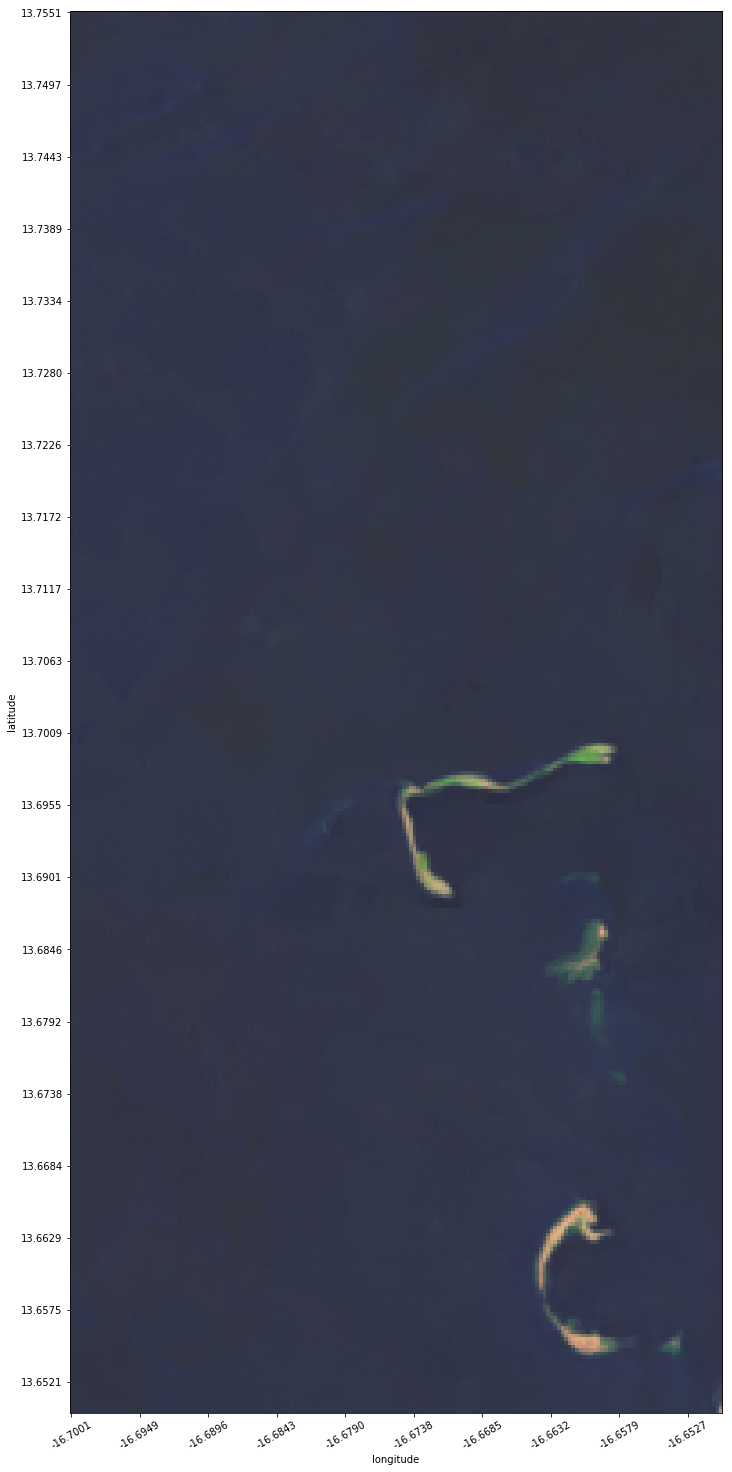

In [11]:
# Show the land and water composite
from utils.data_cube_utilities.dc_rgb import rgb
from utils.data_cube_utilities.plotter_utils import figure_ratio

# RGB image options
# Standard RGB = 321 = Red, Green, Blue
# False Color = 543 = SWIR1, NIR, Red
# False Color (Landsat Mosaic) = 742 = SWIR2, NIR, Green

fig, ax = plt.subplots(figsize=figure_ratio(land_and_water_composite, fixed_width=12))

rgb(land_and_water_composite, bands=['swir2', 'nir', 'green'], 
    min_possible=0, max_possible=5000, fig=fig, ax=ax)
plt.show()

## <span id="obtain_tsm">Obtain TSM [&#9652;](#top)</span>

### Mask Out Everything but Water

In [12]:
from utils.data_cube_utilities.dc_water_classifier import wofs_classify

water_mask = wofs_classify(dataset, clean_mask=clean_mask.values, 
                           no_data=0.0).wofs.astype(np.bool)
water_dataset = dataset.where(water_mask)
water_composite = create_median_mosaic(water_dataset)

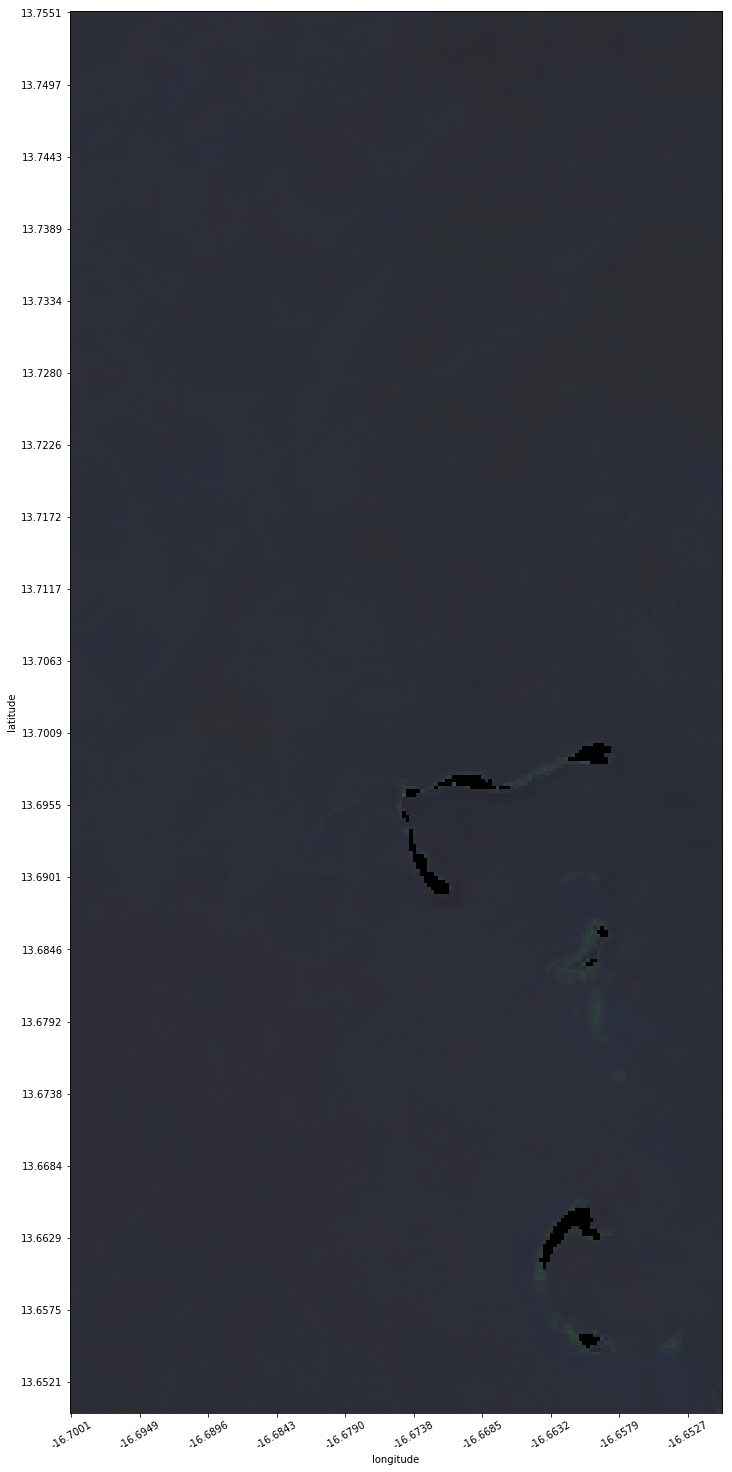

In [13]:
fig, ax = plt.subplots(figsize=figure_ratio(land_and_water_composite, fixed_width=12))

rgb(water_composite, bands=['swir2', 'nir', 'green'], fig=fig, ax=ax)
plt.show()

### Compute TSM

In [14]:
from utils.data_cube_utilities.dc_water_quality import tsm

tsm_dataset = tsm(water_dataset)

### Compute Mean TSM Over Time

In [15]:
mean_tsm = tsm_dataset.mean(dim=['time'])
mean_tsm.tsm.values[np.isnan(mean_tsm.tsm.values)] = 0

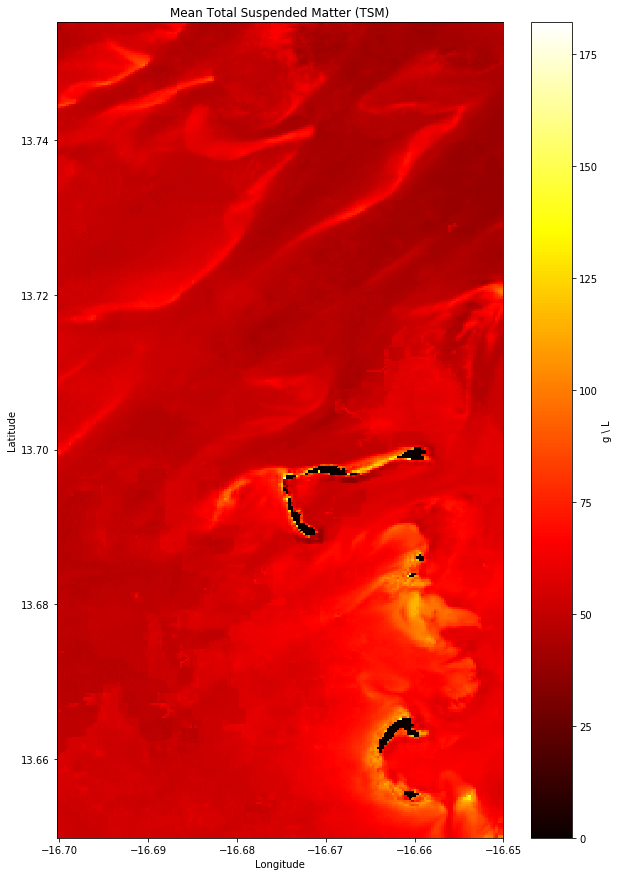

In [16]:
mean_tsm_plot = mean_tsm.tsm.plot(figsize=(10,15), cmap = "hot", 
                                  vmin=mean_tsm.tsm.min(), 
                                  vmax=mean_tsm.tsm.max())
plt.title('Mean Total Suspended Matter (TSM)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
mean_tsm_plot.colorbar.set_label('g \ L')
plt.show()

### Compute Maximum TSM Over Time

In [17]:
max_tsm = tsm_dataset.max(dim=['time'])
max_tsm.tsm.values[np.isnan(max_tsm.tsm.values)] = 0

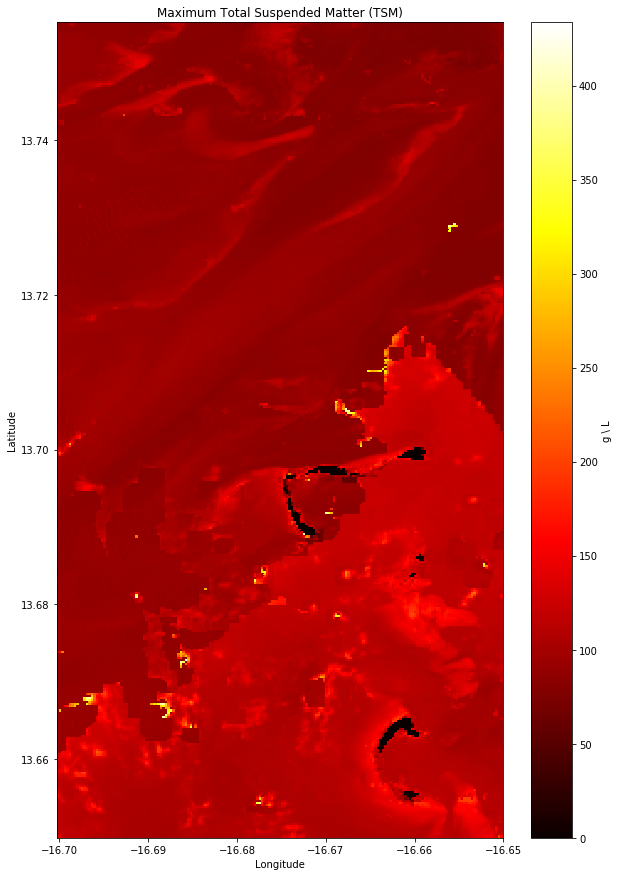

In [18]:
max_tsm_plot = max_tsm.tsm.plot(figsize=(10,15), cmap = "hot", 
                                vmin=max_tsm.tsm.min(), \
                                vmax=max_tsm.tsm.max())
plt.title('Maximum Total Suspended Matter (TSM)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
max_tsm_plot.colorbar.set_label('g \ L')
plt.show()

### Compute Minimum TSM Over Time

In [19]:
minimum_tsm = tsm_dataset.min(dim=['time'])
minimum_tsm.tsm.values[np.isnan(minimum_tsm.tsm.values)] = 0

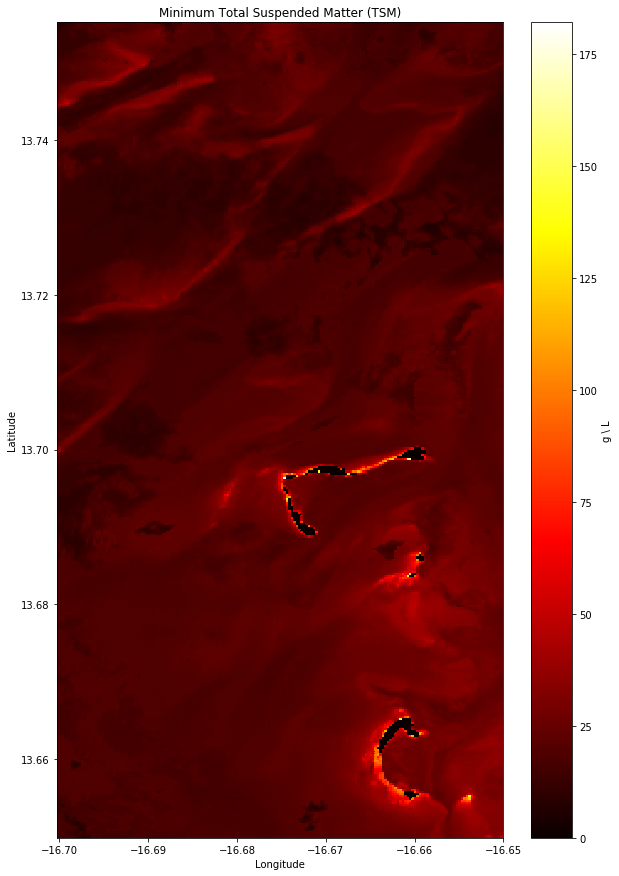

In [20]:
minimum_tsm_plot = minimum_tsm.tsm.plot(figsize=(10,15), cmap = "hot", 
                                        vmin=minimum_tsm.tsm.min(), 
                                        vmax=minimum_tsm.tsm.max())
plt.title('Minimum Total Suspended Matter (TSM)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
minimum_tsm_plot.colorbar.set_label('g \ L')
plt.show()

### Descriptive Statistics

In [21]:
import pandas as pd

tsm_dataframe = tsm_dataset.tsm.to_dataframe()
tsm_statistics = tsm_dataframe.describe()
tsm_statistics = tsm_statistics.append(pd.Series(tsm_dataframe.max() - tsm_dataframe.min(), name='Range'))
first_quartile = tsm_dataframe.quantile(0.25)
third_quartile = tsm_dataframe.quantile(0.75)
tsm_statistics = tsm_statistics.append(pd.Series(third_quartile - first_quartile, name='Interquartile Range'))
tsm_statistics = tsm_statistics.append(pd.Series(tsm_dataframe.var(axis=0), name='Variance'))
tsm_statistics.rename(index={'count' : 'Samples', 'mean' : 'Mean', 'std' : 'Standard Deviation', 'min' : 'Minimum', 
                             '25%' : 'First Quartile', '50%' : 'Second Quartile', '75%' : 'Third Quartile', 'max' : 'Max'}, 
                      columns={'tsm':'TSM'}, inplace=True)
tsm_statistics

,TSM
Samples,1.800629e+06
Mean,5.477909e+01
Standard Deviation,2.707804e+01
Minimum,6.069431e+00
First Quartile,3.130906e+01
Second Quartile,5.240904e+01
Third Quartile,7.617275e+01
Max,4.335540e+02
Range,4.274846e+02
Interquartile Range,4.486369e+01


## <span id="export">GeoTIFF Output Products [&#9652;](#top)</span>

<p style="color:red";><b>CHANGE INPUTS BELOW

In [22]:
from utils.data_cube_utilities.dc_utilities import write_geotiff_from_xr

# Remove the comment to create a GeoTIFF output product
# Change the name of the output file, or it will be overwritten for each run 
# Change the desired bands at the end of the function

# Mean TSM
write_geotiff_from_xr('geotiffs/mean_tsm.tif', mean_tsm, ['tsm'])

# Max TSM
write_geotiff_from_xr('geotiffs/maximum_tsm.tif', max_tsm, ['tsm'])

# Minimum TSM
write_geotiff_from_xr('geotiffs/minimum_tsm.tif', max_tsm, ['tsm'])

In [23]:
!ls -lah geotiffs/*.tif

-rw-rw-r-- 1 localuser localuser 5.5M Sep 27 21:43 geotiffs/Chunking_Demo_WOFS.tif
-rw-rw-r-- 1 localuser localuser 552K Sep 29 19:53 geotiffs/maximum_tsm.tif
-rw-rw-r-- 1 localuser localuser 552K Sep 29 19:53 geotiffs/mean_tsm.tif
-rw-rw-r-- 1 localuser localuser 552K Sep 29 19:53 geotiffs/minimum_tsm.tif
